# Part 3 - Data Analysis

1. Preparation
2. Retrieve the clean data from our SQL-database
3. Split the data into 4 sub-periods and calculate the descriptive statistics for each of them
4. For each asset, run the stationarity test and decide which variable is stationary
5. Conduct several OLS regressions with different combinations of independent variables, choose the most promising model and verify whether the model and the betas are stable over time

## 1. Preparation

In [1]:
#import of the relevant libraries
#without eikon API, since we do not connect to eikon anymore but work with the data from our SQL-database instead

import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import sqlite3
from sqlite3 import Error
import numpy as np
import scipy
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.rolling import RollingOLS 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates 
import itertools as it

#### 1.1 - Generate multiple lists for the data under investigation

In [2]:
#generate a list of the cryptocurrencies
rics_crypto = ['BTC=', #Bitcoin
              'ETH=', #Ethereum
              'XRP=', #Ripple
              'LTC=', #Litecoion
              'BCH='] #Bitcoin Cash

#generate a list of the fiat currencies
rics_currency = ['EUR=', #Euro
                 'GBP=', #Pound Sterling
                 'JPY=', #Japanese Yen
                 'CHF=', #Swiss Francs
                 'CAD='] #Canadian Dollar

#generate a list of the commodities
rics_commodities = ['LCOc1', #Crude Oil (ICE Europe Brent Crude Electronic Energy Future)
                    'WTC-', #Crude Oil (WTI Cushing US FOB)
                    'XAU=', #Gold
                    'XAG=', #Silver
                    '.BCOM', #Bloomberg Commodity Index
                    '.dMIWO0EN00PUS'] #MSCI World Energy Index USD (End of Day)

#generate a list of the stock indices
rics_stockindex = ['.NDX', #Nasdaq 100 Index
                   '.SPX', #S&P 500 Index
                   '.FTSE', #FTSE 100 Index
                   '.CSI300', #China Securities Index 300
                   '.dMIWO00000PUS', #MSCI World Price Index USD (End of Day)
                   '.dMIEF00000PUS', #MSCI Emerging Markets Price Index USD (End of Day)
                   '.dMIEU00000PUS'] #MSCI Europe Price Index USD (End of Day)

#### 1.2 - Generate some further lists which will be helpful later on

In [3]:
#generate a list of all rics
rics = rics_crypto + rics_currency + rics_commodities + rics_stockindex

#generate a list of the dependent variables (y)
rics_dependent_variables = rics_crypto + rics_currency

#generate a list of the independent variables (x)
rics_independent_variables = rics_commodities + rics_stockindex

#generate a list of the desired names of the columns
columns =['Bitcoin',
          'Ethereum',
          'Ripple',
          'Litecoin',
          'Bitcoin Cash',
          'EUR',
          'GBP',
          'JPY',
          'CHF',
          'CAD',
          'Crude Oil ICE',
          'Crude Oil WTI',
          'Gold',
          'Silver',
          'Bloomberg Commodity Index',
          'MSCI World Energy',
          'Nasdaq 100',
          'S&P 500',
          'FTSE 100',
          'CSI 300',
          'MSCI World',
          'MSCI Emerging Markets',
          'MSCI Europe']

#generate a list of the desired names of the columns of the dependent variables (crypto and other currencies)
columns_dependent_variables = ['Bitcoin',
                               'Ethereum',
                               'Ripple',
                               'Litecoin',
                               'Bitcoin Cash',
                               'EUR',
                               'GBP',
                               'JPY',
                               'CHF',
                               'CAD']

#generate a list of the desired names of the columns of the independent variables (commodities & indices)
columns_independent_variables = ['Crude Oil ICE',
                               'Crude Oil WTI',
                               'Gold',
                               'Silver',
                               'Bloomberg Commodity Index',
                               'MSCI World Energy',
                               'Nasdaq 100',
                               'S&P 500',
                               'FTSE 100',
                               'CSI 300',
                               'MSCI World',
                               'MSCI Emerging Markets',
                               'MSCI Europe']

#generate a list of the desired start and end date of the analysis
startdate = '2012-01-04'
enddate = '2022-03-31'

## 2. Retrieve the clean data from our SQL-database

#### 2.1 - Pull all data (dependent & independent variables) from the SQL-database

In [4]:
#pull the data from the SQLite database to python
conn = sqlite3.connect('AQM_Project_Aziz_Oeggerli_Schmid.db')
c = conn.cursor()
c.execute("SELECT * FROM clean_data")
new_data_clean = c.fetchall()


#convert the list to a dataframe using the before defined columns as header
new_data_clean = pd.DataFrame(new_data_clean,columns=['Date','CLOSE','RIC'])


#pivot the tables after RIC and set the date as index --> with the '[rics]', the order of the columns stays the same
new_data_clean = new_data_clean.pivot(index='Date',columns='RIC',values='CLOSE')[rics]


#change the names of the columns of the dataframe
new_data_clean.columns = columns


#switch format of the index to datetime
new_data_clean.index = pd.to_datetime(new_data_clean.index)

print(new_data_clean.shape)
new_data_clean.head()

(1124, 23)


,Bitcoin,Ethereum,Ripple,Litecoin,Bitcoin Cash,EUR,GBP,JPY,CHF,CAD,Crude Oil ICE,Crude Oil WTI,Gold,Silver,Bloomberg Commodity Index,MSCI World Energy,Nasdaq 100,S&P 500,FTSE 100,CSI 300,MSCI World,MSCI Emerging Markets,MSCI Europe
Date,,,,,,,,,,,,,,,,,,,,,,,
2019-03-04,3702.48,125.31,0.30114,45.44,122.91,1.1337,1.3186,111.74,0.9988,1.3302,65.67,56.60,1286.4150,15.0742,80.8184,207.172734,7150.833,2792.81,7134.39,3794.1040,2090.399580,1053.616,1632.467
2019-03-05,3937.60,138.78,0.31261,53.16,130.20,1.1306,1.3175,111.89,1.0040,1.3345,65.86,56.55,1287.1801,15.1222,81.1937,207.120059,7156.785,2789.65,7183.43,3816.0132,2087.502005,1055.117,1632.603
2019-03-06,3945.10,136.35,0.31471,56.39,130.07,1.1305,1.3169,111.75,1.0048,1.3440,65.99,56.22,1286.3600,15.0711,80.7408,205.797671,7112.468,2771.45,7196.00,3848.0903,2078.688801,1055.680,1633.696
2019-03-07,3871.00,141.23,0.31268,56.67,133.83,1.1192,1.3084,111.58,1.0111,1.3453,66.30,56.60,1285.4950,15.0162,80.5200,204.901110,7026.883,2748.93,7157.55,3808.8497,2061.411604,1043.562,1614.594
2019-03-08,3868.30,135.35,0.30762,57.37,128.22,1.1238,1.3015,111.15,1.0078,1.3413,65.74,55.77,1298.0100,15.3100,80.4667,200.989642,7015.690,2743.07,7104.31,3657.5790,2051.123352,1030.127,1600.250


#### 2.2. Pull only the dependent variables from the SQL-database

In [5]:
#pull the data of the dependent variables from the SQLite database to python
conn = sqlite3.connect('AQM_Project_Aziz_Oeggerli_Schmid.db')
c = conn.cursor()
c.execute("SELECT * FROM clean_data WHERE RIC in" + str(tuple(rics_dependent_variables)))
dependent_variables = c.fetchall()


#convert the list to a dataframe using the before defined columns as header
dependent_variables = pd.DataFrame(dependent_variables,columns=['Date','CLOSE','RIC'])


#pivot the tables after RIC and set the date as index --> with the '[rics]', the order of the columns stays the same
dependent_variables = dependent_variables.pivot(index='Date',columns='RIC',values='CLOSE')[rics_dependent_variables]


#change the names of the columns of the dataframe
dependent_variables.columns = columns_dependent_variables


#switch format of the index to datetime
dependent_variables.index = pd.to_datetime(dependent_variables.index)

print(dependent_variables.shape)
dependent_variables.head()

(1124, 10)


,Bitcoin,Ethereum,Ripple,Litecoin,Bitcoin Cash,EUR,GBP,JPY,CHF,CAD
Date,,,,,,,,,,
2019-03-04,3702.48,125.31,0.30114,45.44,122.91,1.1337,1.3186,111.74,0.9988,1.3302
2019-03-05,3937.60,138.78,0.31261,53.16,130.20,1.1306,1.3175,111.89,1.0040,1.3345
2019-03-06,3945.10,136.35,0.31471,56.39,130.07,1.1305,1.3169,111.75,1.0048,1.3440
2019-03-07,3871.00,141.23,0.31268,56.67,133.83,1.1192,1.3084,111.58,1.0111,1.3453
2019-03-08,3868.30,135.35,0.30762,57.37,128.22,1.1238,1.3015,111.15,1.0078,1.3413


#### 2.3 - Pull the independent variables from the SQL-database

In [6]:
#pull the data of the independent variables from the SQLite database to python
conn = sqlite3.connect('AQM_Project_Aziz_Oeggerli_Schmid.db')
c = conn.cursor()
c.execute("SELECT * FROM clean_data WHERE RIC in" + str(tuple(rics_independent_variables)))
independent_variables = c.fetchall()


#convert the list to a dataframe using the before defined columns as header
independent_variables = pd.DataFrame(independent_variables,columns=['Date','CLOSE','RIC'])


#pivot the tables after RIC and set the date as index --> with the '[rics]', the order of the columns stays the same
independent_variables = independent_variables.pivot(index='Date',columns='RIC',values='CLOSE')[rics_independent_variables]


#change the names of the columns of the dataframe
independent_variables.columns = columns_independent_variables


#switch format of the index to datetime
independent_variables.index = pd.to_datetime(independent_variables.index)

print(independent_variables.shape)
independent_variables.head()

(1124, 13)


,Crude Oil ICE,Crude Oil WTI,Gold,Silver,Bloomberg Commodity Index,MSCI World Energy,Nasdaq 100,S&P 500,FTSE 100,CSI 300,MSCI World,MSCI Emerging Markets,MSCI Europe
Date,,,,,,,,,,,,,
2019-03-04,65.67,56.60,1286.4150,15.0742,80.8184,207.172734,7150.833,2792.81,7134.39,3794.1040,2090.399580,1053.616,1632.467
2019-03-05,65.86,56.55,1287.1801,15.1222,81.1937,207.120059,7156.785,2789.65,7183.43,3816.0132,2087.502005,1055.117,1632.603
2019-03-06,65.99,56.22,1286.3600,15.0711,80.7408,205.797671,7112.468,2771.45,7196.00,3848.0903,2078.688801,1055.680,1633.696
2019-03-07,66.30,56.60,1285.4950,15.0162,80.5200,204.901110,7026.883,2748.93,7157.55,3808.8497,2061.411604,1043.562,1614.594
2019-03-08,65.74,55.77,1298.0100,15.3100,80.4667,200.989642,7015.690,2743.07,7104.31,3657.5790,2051.123352,1030.127,1600.250


## 3. Split the data into 4 sub-periods and calculate the descriptive statistics for each of them

#### 3.1 - Create smaller datasets (4 sub-periods)

In [7]:
#create smaller datasets by selecting dates from the index
sample_1 = new_data_clean['2019-04-01':'2019-12-31'] 
sample_2 = new_data_clean['2020-01-01':'2020-09-30'] 
sample_3 = new_data_clean['2020-10-01':'2021-06-30']
sample_4 = new_data_clean['2021-07-01':'2022-03-31']

#### 3.2 - Calculate the descriptive statistices for each of the 4 sub-periods

In [8]:
#create a loop to calculate the most important descriptive statistics (mean,std,min,max) for the 4 subsamples
#if required, this could be amended with additional descr. statistics


#create a list which will then be used as columns
subsample_list=['Statistic','2019-04-01 to 2019-12-31','2020-01-01 to 2020-09-30','2020-10-01 to 2021-06-30','2021-07-01 to 2022-03-31']


#create an empty table and fill it with NaN
def nans(shape, dtype=float):
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a
table_empty = nans([23,5])


#create 4 dataframes, each is used for another descr. statistic (mean,std,min,max), using the before defined list and table
desc_stat_mean = pd.DataFrame(table_empty,columns=subsample_list)
desc_stat_std = pd.DataFrame(table_empty,columns=subsample_list)
desc_stat_min = pd.DataFrame(table_empty,columns=subsample_list)
desc_stat_max = pd.DataFrame(table_empty,columns=subsample_list)

In [9]:
#fill the 4 dataframes (mean, std, min and max) with data of the 4 sub-periods
samples = [sample_1,sample_2,sample_3,sample_4]
a=1
for b in samples:
    for i in range(b.shape[1]):
        if a == 1:
            desc_stat_mean.iloc[i, 0]= "Mean " + b.columns[i]                    #mean
            desc_stat_mean.iloc[i, a]= round (np.average(b[b.columns[i]]),3)     #mean
            desc_stat_std.iloc[i, 0]= "Standard Deviation " + b.columns[i]       #std
            desc_stat_std.iloc[i, a]= round (np.std(b[b.columns[i]]),3)          #std
            desc_stat_min.iloc[i, 0]= "Minimum " + b.columns[i]                  #min
            desc_stat_min.iloc[i, a]= round (np.min(b[b.columns[i]]),3)          #min
            desc_stat_max.iloc[i, 0]= "Maximum " + b.columns[i]                  #max
            desc_stat_max.iloc[i, a]= round (np.max(b[b.columns[i]]),3)          #max
        else:
            desc_stat_mean.iloc[i, a]= round (np.average(b[b.columns[i]]),3)     #mean
            desc_stat_std.iloc[i, a]= round (np.std(b[b.columns[i]]),3)          #std
            desc_stat_min.iloc[i, a]= round (np.min(b[b.columns[i]]),3)          #min
            desc_stat_max.iloc[i, a]= round (np.max(b[b.columns[i]]),3)          #max
    a=a+1

desc_stat_list = [desc_stat_mean, desc_stat_std, desc_stat_min, desc_stat_max]
desc_stat_final = pd.concat(desc_stat_list, keys=["Mean", "Std", "Min", "Max"])
desc_stat_final

Statistic  \
Mean 0                                   Mean Bitcoin   
     1                                  Mean Ethereum   
     2                                    Mean Ripple   
     3                                  Mean Litecoin   
     4                              Mean Bitcoin Cash   
     5                                       Mean EUR   
     6                                       Mean GBP   
     7                                       Mean JPY   
     8                                       Mean CHF   
     9                                       Mean CAD   
     10                            Mean Crude Oil ICE   
     11                            Mean Crude Oil WTI   
     12                                     Mean Gold   
     13                                   Mean Silver   
     14                Mean Bloomberg Commodity Index   
     15                        Mean MSCI World Energy   
     16                               Mean Nasdaq 100   
     17                                  Mean S&P 500   
     18                                 Mean FTSE 100   
     19                                  Mean CSI 300   
     20                               Mean MSCI World   
     21                    Mean MSCI Emerging Markets   
     22                              Mean MSCI Europe   
Std  0                     Standard Deviation Bitcoin   
     1                    Standard Deviation Ethereum   
     2                      Standard Deviation Ripple   
     3                    Standard Deviation Litecoin   
     4                Standard Deviation Bitcoin Cash   
     5                         Standard Deviation EUR   
     6                         Standard Deviation GBP   
     7                         Standard Deviation JPY   
     8                         Standard Deviation CHF   
     9                         Standard Deviation CAD   
     10              Standard Deviation Crude Oil ICE   
     11              Standard Deviation Crude Oil WTI   
     12                       Standard Deviation Gold   
     13                     Standard Deviation Silver   
     14  Standard Deviation Bloomberg Commodity Index   
     15          Standard Deviation MSCI World Energy   
     16                 Standard Deviation Nasdaq 100   
     17                    Standard Deviation S&P 500   
     18                   Standard Deviation FTSE 100   
     19                    Standard Deviation CSI 300   
     20                 Standard Deviation MSCI World   
     21      Standard Deviation MSCI Emerging Markets   
     22                Standard Deviation MSCI Europe   
Min  0                                Minimum Bitcoin   
     1                               Minimum Ethereum   
     2                                 Minimum Ripple   
     3                               Minimum Litecoin   
     4                           Minimum Bitcoin Cash   
     5                                    Minimum EUR   
     6                                    Minimum GBP   
     7                                    Minimum JPY   
     8                                    Minimum CHF   
     9                                    Minimum CAD   
     10                         Minimum Crude Oil ICE   
     11                         Minimum Crude Oil WTI   
     12                                  Minimum Gold   
     13                                Minimum Silver   
     14             Minimum Bloomberg Commodity Index   
     15                     Minimum MSCI World Energy   
     16                            Minimum Nasdaq 100   
     17                               Minimum S&P 500   
     18                              Minimum FTSE 100   
     19                               Minimum CSI 300   
     20                            Minimum MSCI World   
     21                 Minimum MSCI Emerging Markets   
     22                           Minimum MSCI Europe   
Max  0                                Maximum Bitcoin 

#### 3.3 - Export and save the data

In [10]:
#export this table to excel and save it
desc_stat_final.to_excel("Desc_stats/AQM_Project_Aziz_Oeggerli_Schmid_descriptive_statistics.xls")

<ipython-input-10-d9eededacfa7>:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  desc_stat_final.to_excel("Desc_stats/AQM_Project_Aziz_Oeggerli_Schmid_descriptive_statistics.xls")


## 4. For each asset, run the stationarity test and decide which variable is stationary

In [11]:
?adfuller

#### 4.1 - We check whether we have stationarity in the dependent variables (cryptos & fiat currencies --> y-values)

In [12]:
#run the Dickey-Fuller-Test to test the dependent variables for stationarity (in a first step for the actual values)

for lags in range(1,3):
    print('Number of lags used:',lags)
    print('ADF P-Val for Prices (Level)')
    for i in columns_dependent_variables:
        adf_library = adfuller(dependent_variables[i], maxlag=lags, regression='nc',autolag=None)
        adf_library_d = adfuller(np.diff(dependent_variables[i]), maxlag=lags, regression='nc',autolag=None)

        print(i,':',"%.2f" %  adf_library[1],)
    print('____________________________________________','\n') 

Number of lags used: 1
ADF P-Val for Prices (Level)
Bitcoin : 0.77
Ethereum : 0.76
Ripple : 0.36
Litecoin : 0.37
Bitcoin Cash : 0.31
EUR : 0.60
GBP : 0.65
JPY : 0.88
CHF : 0.38
CAD : 0.47
____________________________________________ 

Number of lags used: 2
ADF P-Val for Prices (Level)
Bitcoin : 0.76
Ethereum : 0.75
Ripple : 0.35
Litecoin : 0.34
Bitcoin Cash : 0.32
EUR : 0.60
GBP : 0.65
JPY : 0.87
CHF : 0.39
CAD : 0.44
____________________________________________ 



In [13]:
#the result shows, that the p-value lies above the critical p-value (on all confidence levels - 10%, 5% & 1%)
#therefore, we take the absolute returns (1st Difference) and run a second Dickey-Fuller-Test 
#this time the results lies under the critical p-value (on all confidence levels - 10%, 5% & 1%)
#meaning that we can reject the null hypothesis (H0) which means that there is no unit root (=stationarity) 

for lags in range(1,3):
    print('Number of lags used:',lags)
    print('ADF P-Val for Absolute Returns (1st Difference)')
    for i in columns_dependent_variables:
        adf_library = adfuller(dependent_variables[i], maxlag=lags, regression='nc',autolag=None)
        adf_library_d = adfuller(np.diff(dependent_variables[i]), maxlag=lags, regression='nc',autolag=None)

        print(i,':',"%.2f" %  adf_library_d[1])
    print('____________________________________________','\n')

Number of lags used: 1
ADF P-Val for Absolute Returns (1st Difference)
Bitcoin : 0.00
Ethereum : 0.00
Ripple : 0.00
Litecoin : 0.00
Bitcoin Cash : 0.00
EUR : 0.00
GBP : 0.00
JPY : 0.00
CHF : 0.00
CAD : 0.00
____________________________________________ 

Number of lags used: 2
ADF P-Val for Absolute Returns (1st Difference)
Bitcoin : 0.00
Ethereum : 0.00
Ripple : 0.00
Litecoin : 0.00
Bitcoin Cash : 0.00
EUR : 0.00
GBP : 0.00
JPY : 0.00
CHF : 0.00
CAD : 0.00
____________________________________________ 



#### 4.2 - We check whether we have stationarity in the independent variables (commodities & stock indices --> x-values)

In [14]:
#run the Dickey-Fuller-Test to test the independent variables for stationarity (in a first step for the actual values)

for lags in range(1,3):
    print('Number of lags used:',lags)
    print('ADF P-Val for Prices (Level)')
    for i in columns_independent_variables:
        adf_library = adfuller(independent_variables[i], maxlag=lags, regression='nc',autolag=None)
        adf_library_d = adfuller(np.diff(independent_variables[i]), maxlag=lags, regression='nc',autolag=None)

        print(i,':',"%.2f" %  adf_library[1],)
    print('____________________________________________','\n')

Number of lags used: 1
ADF P-Val for Prices (Level)
Crude Oil ICE : 0.88
Crude Oil WTI : 0.80
Gold : 0.93
Silver : 0.82
Bloomberg Commodity Index : 0.99
MSCI World Energy : 0.69
Nasdaq 100 : 0.97
S&P 500 : 0.96
FTSE 100 : 0.69
CSI 300 : 0.70
MSCI World : 0.94
MSCI Emerging Markets : 0.70
MSCI Europe : 0.78
____________________________________________ 

Number of lags used: 2
ADF P-Val for Prices (Level)
Crude Oil ICE : 0.89
Crude Oil WTI : 0.85
Gold : 0.94
Silver : 0.82
Bloomberg Commodity Index : 0.99
MSCI World Energy : 0.69
Nasdaq 100 : 0.97
S&P 500 : 0.96
FTSE 100 : 0.68
CSI 300 : 0.70
MSCI World : 0.93
MSCI Emerging Markets : 0.70
MSCI Europe : 0.77
____________________________________________ 



In [15]:
#the result shows, that the p-value lies above the critical p-value (on all confidence levels - 10%, 5% & 1%)
#therefore, we take the absolute returns (1st Difference) and run a second Dickey-Fuller-Test 
#this time the results lies under the critical p-value (on all confidence levels - 10%, 5% & 1%)
#meaning that we can reject the null hypothesis (H0) which means that there is no unit root (=stationarity) 


for lags in range(1,3):
    print('Number of lags used:',lags)
    print('ADF P-Val for Absolute Returns (1st Difference)')
    for i in columns_independent_variables:
        adf_library = adfuller(independent_variables[i], maxlag=lags, regression='nc',autolag=None)
        adf_library_d = adfuller(np.diff(independent_variables[i]), maxlag=lags, regression='nc',autolag=None)

        print(i,':',"%.2f" %  adf_library_d[1])
    print('____________________________________________','\n')

Number of lags used: 1
ADF P-Val for Absolute Returns (1st Difference)
Crude Oil ICE : 0.00
Crude Oil WTI : 0.00
Gold : 0.00
Silver : 0.00
Bloomberg Commodity Index : 0.00
MSCI World Energy : 0.00
Nasdaq 100 : 0.00
S&P 500 : 0.00
FTSE 100 : 0.00
CSI 300 : 0.00
MSCI World : 0.00
MSCI Emerging Markets : 0.00
MSCI Europe : 0.00
____________________________________________ 

Number of lags used: 2
ADF P-Val for Absolute Returns (1st Difference)
Crude Oil ICE : 0.00
Crude Oil WTI : 0.00
Gold : 0.00
Silver : 0.00
Bloomberg Commodity Index : 0.00
MSCI World Energy : 0.00
Nasdaq 100 : 0.00
S&P 500 : 0.00
FTSE 100 : 0.00
CSI 300 : 0.00
MSCI World : 0.00
MSCI Emerging Markets : 0.00
MSCI Europe : 0.00
____________________________________________ 



## 5. Conduct several OLS regressions with different combinations of independent variables, choose the most promising model and verify whether the model and the betas are stable over time

#### 5.1 - We generate a new table with daily returns

In [16]:
#generate a new dataframe which shows the daily returns of the assets (which makes the different data comparable)
daily_returns = new_data_clean.pct_change()
daily_returns.dropna(inplace=True)

In [17]:
#test for stationarity of the new data (daily returns) 
#the results shows, that there is no unit root (=stationarity) 

for lags in range(1,3):
    print('Number of lags used:',lags)
    print('ADF P-Val for Prices (Level)')
    for i in columns:
        adf_library = adfuller(daily_returns[i], maxlag=lags, regression='nc',autolag=None)
        adf_library_d = adfuller(np.diff(daily_returns[i]), maxlag=lags, regression='nc',autolag=None)

        print(i,':',"%.2f" %  adf_library[1],)
    print('____________________________________________','\n')

Number of lags used: 1
ADF P-Val for Prices (Level)
Bitcoin : 0.00
Ethereum : 0.00
Ripple : 0.00
Litecoin : 0.00
Bitcoin Cash : 0.00
EUR : 0.00
GBP : 0.00
JPY : 0.00
CHF : 0.00
CAD : 0.00
Crude Oil ICE : 0.00
Crude Oil WTI : 0.00
Gold : 0.00
Silver : 0.00
Bloomberg Commodity Index : 0.00
MSCI World Energy : 0.00
Nasdaq 100 : 0.00
S&P 500 : 0.00
FTSE 100 : 0.00
CSI 300 : 0.00
MSCI World : 0.00
MSCI Emerging Markets : 0.00
MSCI Europe : 0.00
____________________________________________ 

Number of lags used: 2
ADF P-Val for Prices (Level)
Bitcoin : 0.00
Ethereum : 0.00
Ripple : 0.00
Litecoin : 0.00
Bitcoin Cash : 0.00
EUR : 0.00
GBP : 0.00
JPY : 0.00
CHF : 0.00
CAD : 0.00
Crude Oil ICE : 0.00
Crude Oil WTI : 0.00
Gold : 0.00
Silver : 0.00
Bloomberg Commodity Index : 0.00
MSCI World Energy : 0.00
Nasdaq 100 : 0.00
S&P 500 : 0.00
FTSE 100 : 0.00
CSI 300 : 0.00
MSCI World : 0.00
MSCI Emerging Markets : 0.00
MSCI Europe : 0.00
____________________________________________ 



#### 5.2 - Conduct a random/single OLS analysis and compare the prediction with the acutal value (not used later on, only for illustration purposes)


In [18]:
#conduct a random/single OLS analysis 
#(not used, because we will later on create a loop to run all different combinations of x and y variables)

Y = daily_returns['Bitcoin']
X = daily_returns[['Silver','S&P 500','MSCI World','MSCI Europe']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Bitcoin   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     30.38
Date:                Mon, 16 May 2022   Prob (F-statistic):           4.95e-24
Time:                        19:36:38   Log-Likelihood:                 2095.8
No. Observations:                1123   AIC:                            -4182.
Df Residuals:                    1118   BIC:                            -4157.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0025      0.001      2.208      0.027       0.000       0.005
Silver          0.3472      0.071      4.916      0.000       0.209       0.486
S&P 500        -0.6106      0.769     -0.793      0.428      -2.120       0.899
MSCI World      1.7390      1.122      1.549      0.122      -0.463       3.941
MSCI Europe    -0.1278      0.307     -0.416      0.677      -0.731       0.475
==============================================================================
Omnibus:                       96.230   Durbin-Watson:                   2.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              441.132
Skew:                           0.246   Prob(JB):                     1.62e-96
Kurtosis:                       6.031   Cond. No.                     1.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

             Bitcoin  Prediction
Date                            
2019-03-05  0.063503    0.001851
2019-03-06  0.001905   -0.002142
2019-03-07 -0.018783   -0.006787
2019-03-08 -0.000697    0.003027
2019-03-09  0.005550    0.002476


<function matplotlib.pyplot.show(close=None, block=None)>

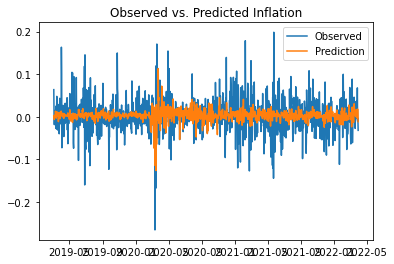

In [19]:
#compare the prediction with the actual value (in a dataframe)
regression1 = pd.DataFrame(Y)
prediction = results.predict()
regression1['Prediction']=prediction
print(regression1.head())

#and in a chart
plt.plot(regression1)
labels=['Observed','Prediction']
plt.legend(labels)
plt.title('Observed vs. Predicted Inflation')
plt.show

#### 5.3 - Test all different combinations of independent variables (x) for every dependent variable (y) and choose the most promissing regression

5.3.1 - We define some functions, which will be used for our analysis

In [20]:
#function for the chow test

def chow_test(Y,X,p_val=0.05):
    
    # Model for the first half
    Y_1 = Y[:round(Y.shape[0]/2)]
    X_1 = X[:round(Y.shape[0]/2)]

    # Model for the second half
    Y_2 = Y[round(Y.shape[0]/2):]
    X_2 = X[round(Y.shape[0]/2):]


    J = X.shape[1] #Amount of explanatory variables
    k = X_1.shape[1] #Amount of explanatory Variables
    N1 = X_1.shape[0] #length first period
    N2 = X_2.shape[0] #length second period

    #Fit OLS Regression
    model_full = sm.OLS(Y,X).fit() #fit regression on the full period
    RSS = model_full.ssr #RSS full period

    model_1 = sm.OLS(Y_1,X_1).fit() #fit regression
    RSS1 = model_1.ssr #RSS second period
    model_2 = sm.OLS(Y_2,X_2).fit() #fit regression
    RSS2 = model_2.ssr #RSS first period

    chow = ((RSS-(RSS1+RSS2))/J)/((RSS1+RSS2)/(N1+N2-2*k))
    f_cdf = scipy.stats.f.cdf(chow, J, N1+N2-2*k)
    if (1-f_cdf) < p_val:
        print("P-Value for "+Y.name+" is " + str(round(1-f_cdf,2))+": Null Hypothesis rejected.\nThere is a structural break and therefore a unexpected/unconventional change over time in the parameters of the OLS regression model")
    else:
        print("P-Value for "+Y.name+" is " + str(round(1-f_cdf,2))+": Null Hypothesis cannot be rejected.\nThere is no structural break and therefore no unexpected/unconventional change over time in the parameters of the OLS regression model")
    return (f_cdf)


In [21]:
#function for the rolling regression

def rolling_regression(y, x, window,method = "package"):
    #Check if NaN are available
    if y.isnull().values.any() == True or x.isnull().values.any()==True:
        print("There are some NaN in the data.\nPlease clean up the data.")
        return None
    #Confirmation that all time series have the same length
    if x.index.size > y.index.size:
        x = x[y.index]
        print("The length of the explanatory variables is larger than the length of the target variable")
    elif x.index.size < y.index.size:
        y = y[x.index]
        print("The length of the target variable is larger than the length of the explanatory variables")
    else:
        print("The length of the explanatory variables corresponds to the length of the target variable")
    #Check window-size
    if y.index.size < window:
        print("Window-size is larger than the length of the data => impossible - try smaller window-size")
        return None
    #calculate rolling regression - own calculation
    if method == "own":
        estimated_betas = pd.DataFrame(index = x.index, columns = [i for i in x.columns]) #empty DataFrame
        for i in range(window, x.index.size+1):
            X_slice = X.values[i-window:i,:] #values (length = window) => rolling
            y_slice = y.values[i-window:i] #values  (length = window) => rolling
            coeff = np.dot(np.dot(np.linalg.inv(np.dot(X_slice.T, X_slice)), X_slice.T), y_slice) #(XT*X)^-1*XT*Y #estimated Betas
            estimated_betas.iloc[i-1,:] = coeff
    else:
        #Package RollingOLS from statsmodels
        rolling_ols = RollingOLS(endog =y , exog=x,window = window)
        rolling_ols_results = rolling_ols.fit(cov_type = "HC0")
        estimated_betas = rolling_ols_results.params
        # === Assemble ========================================================
        #estimate = pd.Series(data=estimate_data, index=x.index[window-1:]) 
    return estimated_betas

In [22]:
#function which allows us to test all different combinations of independent variables (x) for every dependent variable (y)

def OLS_regression_all_combinations(y,x,features_list):
    rsquared_adj_list = [] #create empty list
    for i in features_list: 
        X_features = x[i] #different conbination of explanatory variables
        model = sm.OLS(y,X_features) #model
        results = model.fit(cov_type = "HC0") #model fit
        rsquared_adj_list.append(results.rsquared_adj) #append adjusted r squared to list
    return(rsquared_adj_list)

5.3.2 - Create all necessary datasets for the OLS 

In [23]:
#generate a new dataframe which shows the daily returns of all assets
daily_returns = new_data_clean.pct_change()
daily_returns.dropna(inplace=True)

#generate a new dataframe which shows the daily returns of the dependent variables (cryptos & other currencies)
y_input = dependent_variables.pct_change()
y_input = y_input.dropna()
display(y_input.head())

#generate a new dataframe which shows the daily returns of the independent variables (commodities & stock indices)
x_input = independent_variables.pct_change()
x_input = sm.add_constant(x_input)
x_input = x_input.dropna()
display(x_input.head())

,Bitcoin,Ethereum,Ripple,Litecoin,Bitcoin Cash,EUR,GBP,JPY,CHF,CAD
Date,,,,,,,,,,
2019-03-05,0.063503,0.107493,0.038089,0.169894,0.059312,-0.002734,-0.000834,0.001342,0.005206,0.003233
2019-03-06,0.001905,-0.017510,0.006718,0.060760,-0.000998,-0.000088,-0.000455,-0.001251,0.000797,0.007119
2019-03-07,-0.018783,0.035790,-0.006450,0.004965,0.028908,-0.009996,-0.006455,-0.001521,0.006270,0.000967
2019-03-08,-0.000697,-0.041634,-0.016183,0.012352,-0.041919,0.004110,-0.005274,-0.003854,-0.003264,-0.002973
2019-03-09,0.005550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,const,Crude Oil ICE,Crude Oil WTI,Gold,Silver,Bloomberg Commodity Index,MSCI World Energy,Nasdaq 100,S&P 500,FTSE 100,CSI 300,MSCI World,MSCI Emerging Markets,MSCI Europe
Date,,,,,,,,,,,,,,
2019-03-05,1.0,0.002893,-0.000883,0.000595,0.003184,0.004644,-0.000254,0.000832,-0.001131,0.006874,0.005775,-0.001386,0.001425,0.000083
2019-03-06,1.0,0.001974,-0.005836,-0.000637,-0.003379,-0.005578,-0.006385,-0.006192,-0.006524,0.001750,0.008406,-0.004222,0.000534,0.000669
2019-03-07,1.0,0.004698,0.006759,-0.000672,-0.003643,-0.002735,-0.004357,-0.012033,-0.008126,-0.005343,-0.010197,-0.008312,-0.011479,-0.011693
2019-03-08,1.0,-0.008446,-0.014664,0.009736,0.019566,-0.000662,-0.019090,-0.001593,-0.002132,-0.007438,-0.039716,-0.004991,-0.012874,-0.008884
2019-03-09,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


5.3.3 - Create a list of all possible combinations of dependent and independent variables (y and x) if we use at least 5 different independent variables

In [24]:
#define the number of all possible combinations of x for each y (if we use at least 5 independent variables)

features = x_input.columns.values
features_list = []
for i in range(5,len(features)+1):
    combinations = list(it.combinations(features,i)) #create all possible combinations with the length i => list of tuples
    combinations = [list(elem) for elem in combinations] #transform into list of list
    features_list += combinations
features_list
print('Number of independent variables is: ' + str(len(features)))
print('Number of different combinations of independent variables for each dependent variable is: ' + str(len(features_list)))

Number of independent variables is: 14
Number of different combinations of independent variables for each dependent variable is: 14913


5.3.4 - Run all different combinations of independent variables (at least 5) for every dependent variable (y) and save the results (the adjusted r-squared value) into a txt-file

In [25]:
#this will take about 5-10min

for i in y_input.columns:
    Y = y_input[i] #get target variable
    print(i+"_rsquared_adj_list.txt") #print name of the txt file as confirmation
    rsquared_adj_list = OLS_regression_all_combinations(Y,x_input,features_list) #call function
    np.savetxt('Adj_r_squared/'+i+"_rsquared_adj_list.txt",rsquared_adj_list) #save adjusted r squared list as txt file

Bitcoin_rsquared_adj_list.txt
Ethereum_rsquared_adj_list.txt
Ripple_rsquared_adj_list.txt
Litecoin_rsquared_adj_list.txt
Bitcoin Cash_rsquared_adj_list.txt
EUR_rsquared_adj_list.txt
GBP_rsquared_adj_list.txt
JPY_rsquared_adj_list.txt
CHF_rsquared_adj_list.txt
CAD_rsquared_adj_list.txt


5.3.5 - Load the adj. r-squared values back into python, create a list out of it and combine the different lists into one

In [26]:
Bitcoin_r_squared_adj_list = list(np.loadtxt('Adj_r_squared/Bitcoin_rsquared_adj_list.txt'))
Ethereum_r_squared_adj_list = list(np.loadtxt('Adj_r_squared/Ethereum_rsquared_adj_list.txt'))
Ripple_r_squared_adj_list = list(np.loadtxt('Adj_r_squared/Ripple_rsquared_adj_list.txt'))
Litecoin_r_squared_adj_list = list(np.loadtxt('Adj_r_squared/Litecoin_rsquared_adj_list.txt'))
Bitcoin_Cash_r_squared_adj_list = list(np.loadtxt('Adj_r_squared/Bitcoin Cash_rsquared_adj_list.txt'))
EUR_r_squared_adj_list = list(np.loadtxt('Adj_r_squared/EUR_rsquared_adj_list.txt'))
GBP_r_squared_adj_list = list(np.loadtxt('Adj_r_squared/GBP_rsquared_adj_list.txt'))
JPY_r_squared_adj_list = list(np.loadtxt('Adj_r_squared/JPY_rsquared_adj_list.txt'))
CHF_r_squared_adj_list = list(np.loadtxt('Adj_r_squared/CHF_rsquared_adj_list.txt'))
CAD_r_squared_adj_list = list(np.loadtxt('Adj_r_squared/CAD_rsquared_adj_list.txt'))

#combine all lists into one list
r_squared_adjusted_list = [Bitcoin_r_squared_adj_list,
                           Ethereum_r_squared_adj_list,
                           Ripple_r_squared_adj_list,
                           Litecoin_r_squared_adj_list,
                           Bitcoin_Cash_r_squared_adj_list,
                           EUR_r_squared_adj_list,
                           GBP_r_squared_adj_list,
                           JPY_r_squared_adj_list,
                           CHF_r_squared_adj_list,
                           CAD_r_squared_adj_list]

5.3.6 - Create a dataframe of the adj. r-squared values and show the highest adj. r-squared value (which represents the best model)

In [27]:
#create a dataframe with all adj. r-squared values and show the highest value (=the best regression model) for each dependent variable

all_r_squared_adjusted = pd.DataFrame(r_squared_adjusted_list) #convert list to df
all_r_squared_adjusted = all_r_squared_adjusted.T #switch columns & rows (=transpose)
all_r_squared_adjusted.columns = columns_dependent_variables #switch columns
display(all_r_squared_adjusted.head())        
all_r_squared_adjusted.max()

,Bitcoin,Ethereum,Ripple,Litecoin,Bitcoin Cash,EUR,GBP,JPY,CHF,CAD
0,0.051403,0.043537,0.017371,0.041591,0.029682,0.119709,0.088376,0.272598,0.201305,0.207673
1,0.030514,0.034200,0.011975,0.026980,0.022089,0.112344,0.080480,0.269227,0.201618,0.192140
2,0.051011,0.045053,0.017987,0.036552,0.030864,0.124686,0.128790,0.286115,0.201262,0.363934
3,0.087446,0.086910,0.036134,0.064951,0.050035,0.113497,0.086811,0.326746,0.202573,0.253277
4,0.077865,0.077838,0.033087,0.060929,0.047286,0.116924,0.104349,0.340650,0.202274,0.308867


Bitcoin         0.121620
Ethereum        0.116140
Ripple          0.058660
Litecoin        0.094113
Bitcoin Cash    0.076428
EUR             0.349762
GBP             0.450972
JPY             0.423140
CHF             0.336599
CAD             0.454870
dtype: float64

In [28]:
#Upload the data into our SQL table

#create a SQLite table
conn = sqlite3.connect('AQM_Project_Aziz_Oeggerli_Schmid.db')
c = conn.cursor()
c.execute('''CREATE TABLE adj_r_squared
            (RIC char(60),
             R_Squared char(60) NOT NULL)''')
print("Table created successfully")


#change the names of the columns back to the RIC's (so that the names are the same all over the database)
all_r_squared_adjusted.columns = rics_dependent_variables


#transformation into long format and new column names
all_r_squared_adjusted_to_insert = pd.melt(all_r_squared_adjusted, value_vars = all_r_squared_adjusted.columns.values.tolist()[:-1])
all_r_squared_adjusted_to_insert.columns = ['RIC','R_Squared']


#transform the all_data_merged dataframe to a list
#this needs to be done so that we can insert the data into the before created SQLite database
all_r_squared_adjusted_to_insert_list = all_r_squared_adjusted_to_insert.values.tolist()


#upload the data to our SQLite database
c = conn.cursor()
c.executemany("INSERT INTO adj_r_squared(RIC, R_Squared) VALUES (?,?)", all_r_squared_adjusted_to_insert_list)    
conn.commit()

print("Upload to SQL-database successful")

Table created successfully
Upload to SQL-database successful


#### 5.4 - For each regression run the Chow test in the middle of the sample and rolling window regressions to see whether model and the Betas are stable over time

0
Bitcoin
Maximal R Squared: 0.12161962926583869
The length of the explanatory variables corresponds to the length of the target variable
P-Value for Bitcoin is 0.15: Null Hypothesis cannot be rejected.
There is no structural break and therefore no unexpected/unconventional change over time in the parameters of the OLS regression model
_____________________________________________________
1
Ethereum
Maximal R Squared: 0.11614016699230423
The length of the explanatory variables corresponds to the length of the target variable
P-Value for Ethereum is 0.23: Null Hypothesis cannot be rejected.
There is no structural break and therefore no unexpected/unconventional change over time in the parameters of the OLS regression model
_____________________________________________________
2
Ripple
Maximal R Squared: 0.058659703282064046
The length of the explanatory variables corresponds to the length of the target variable
P-Value for Ripple is 0.02: Null Hypothesis rejected.
There is a structural 

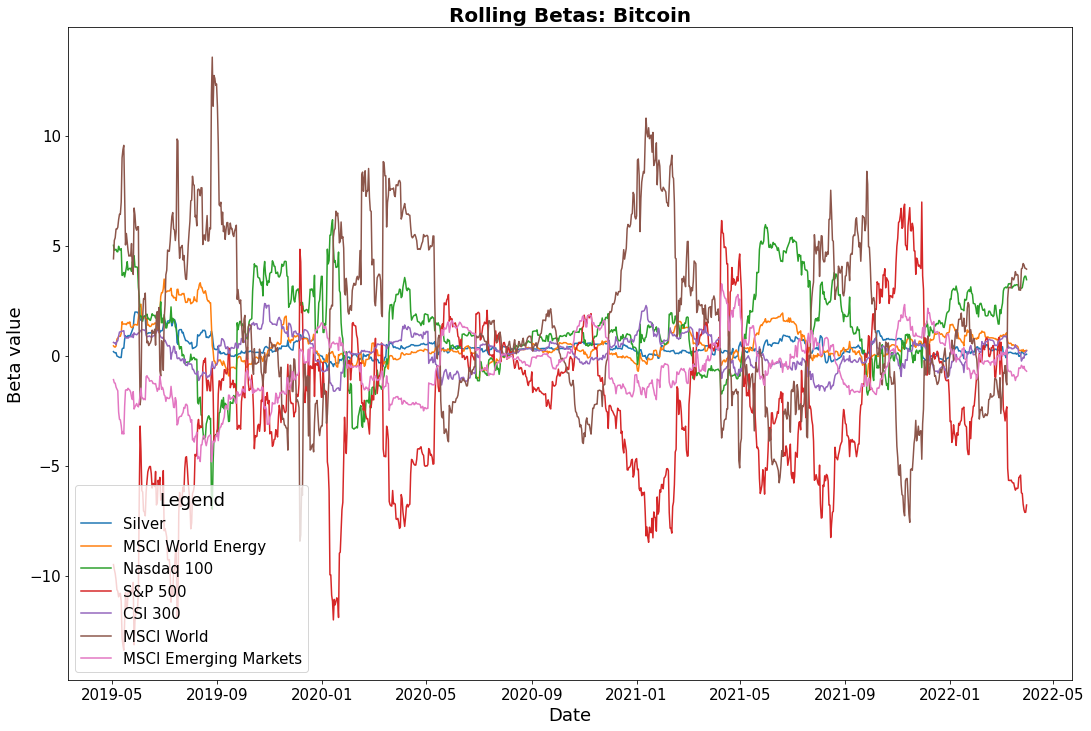

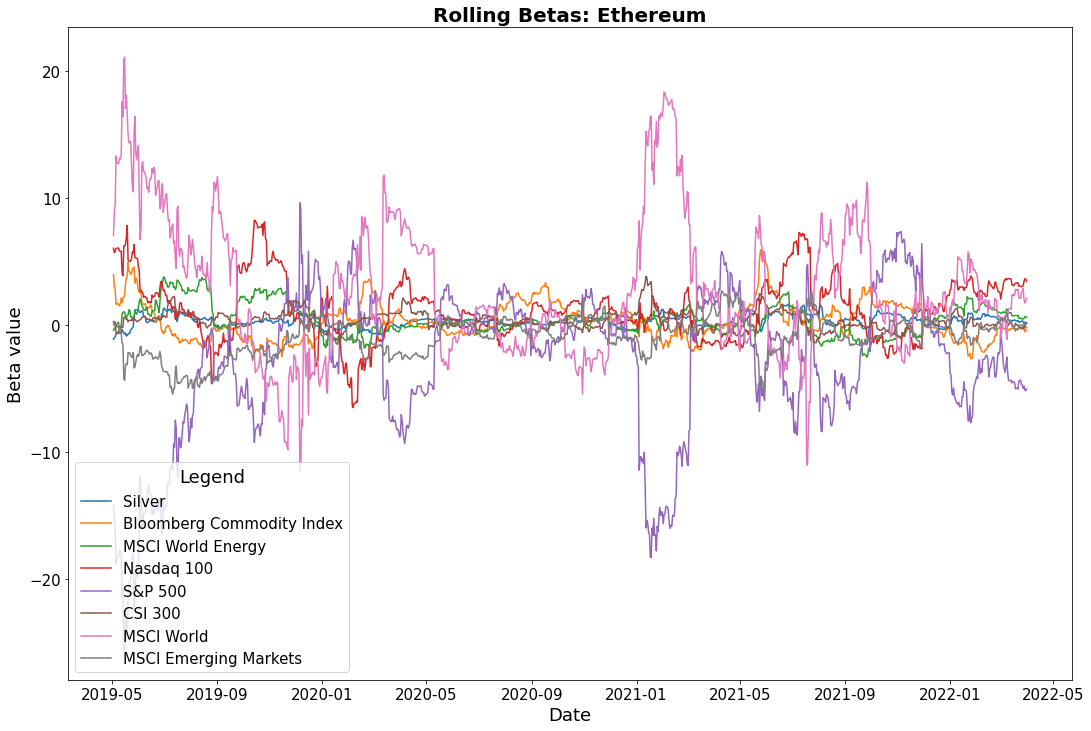

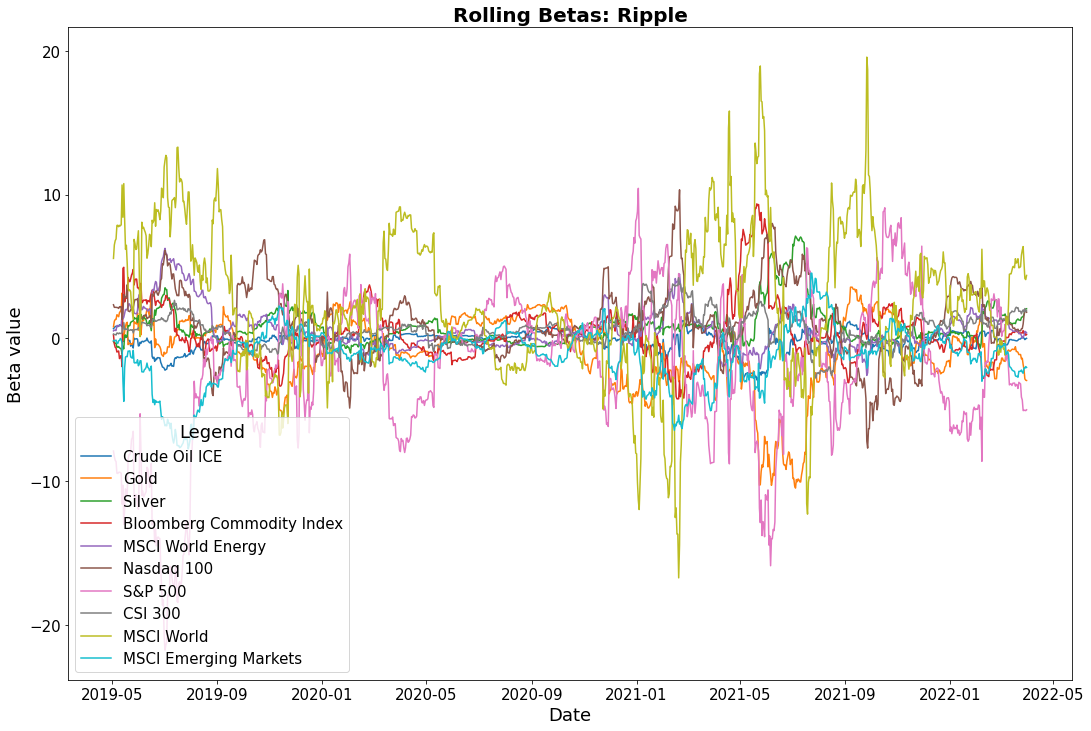

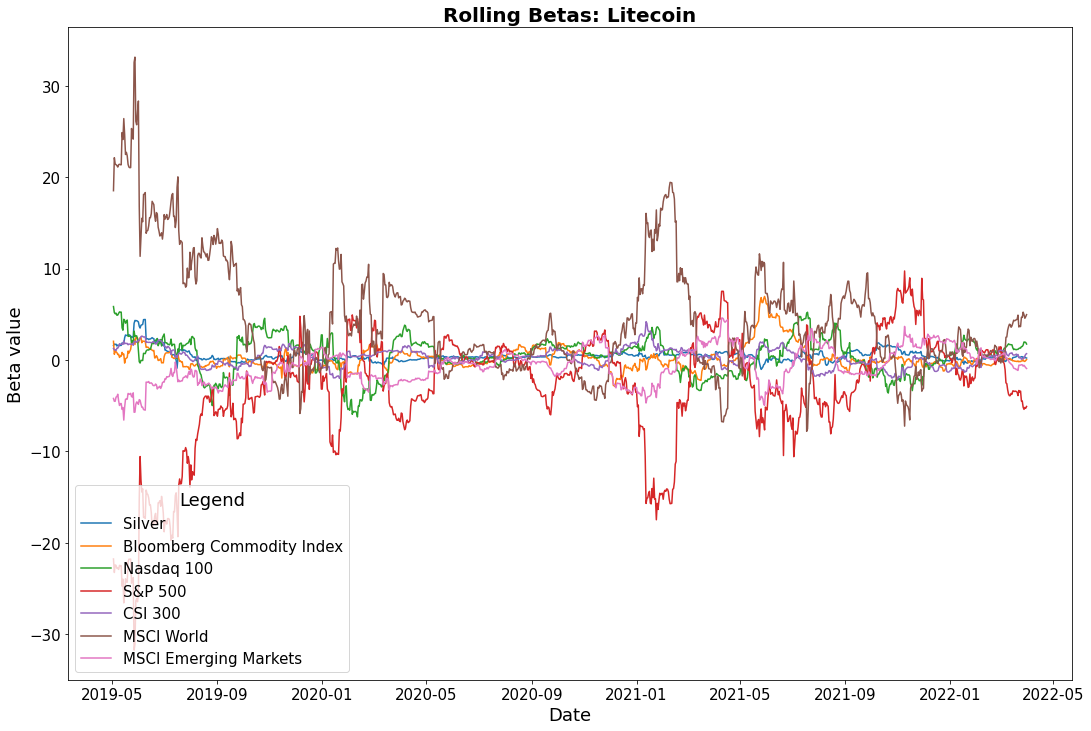

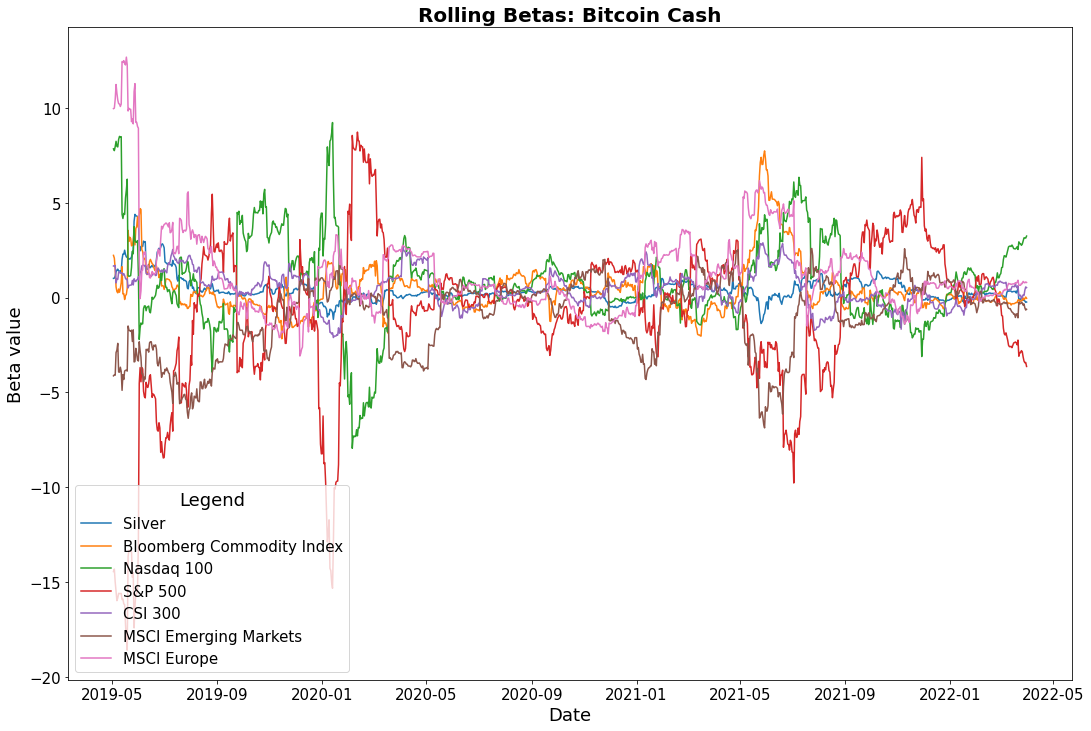

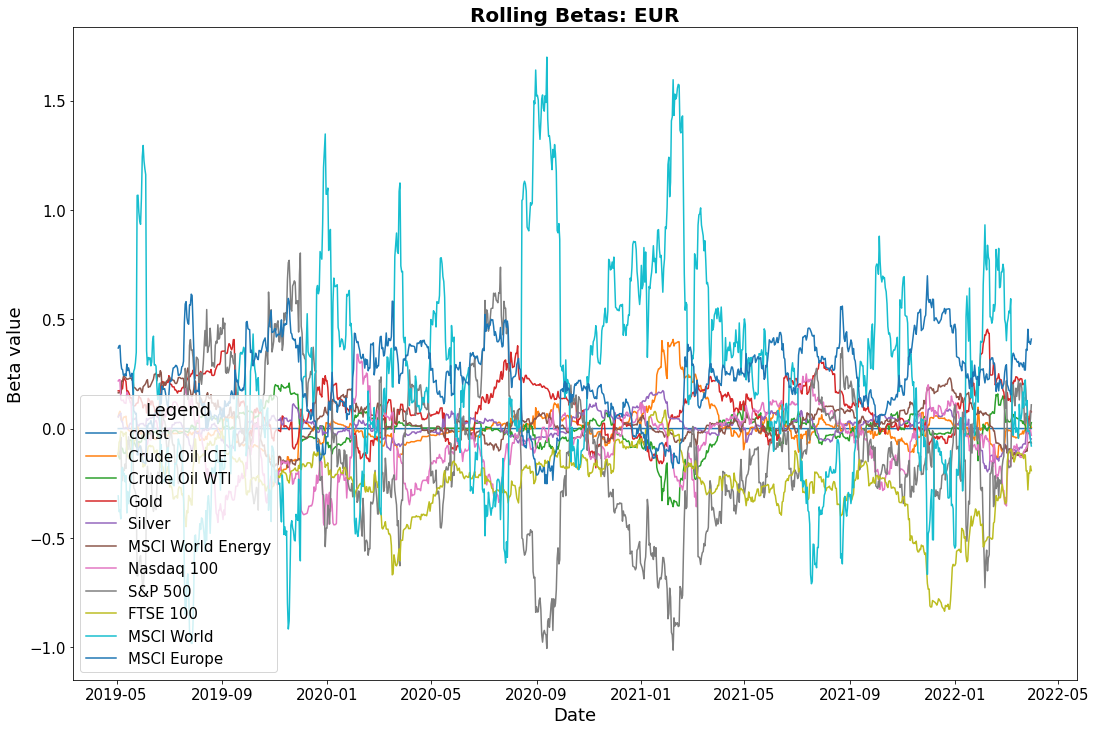

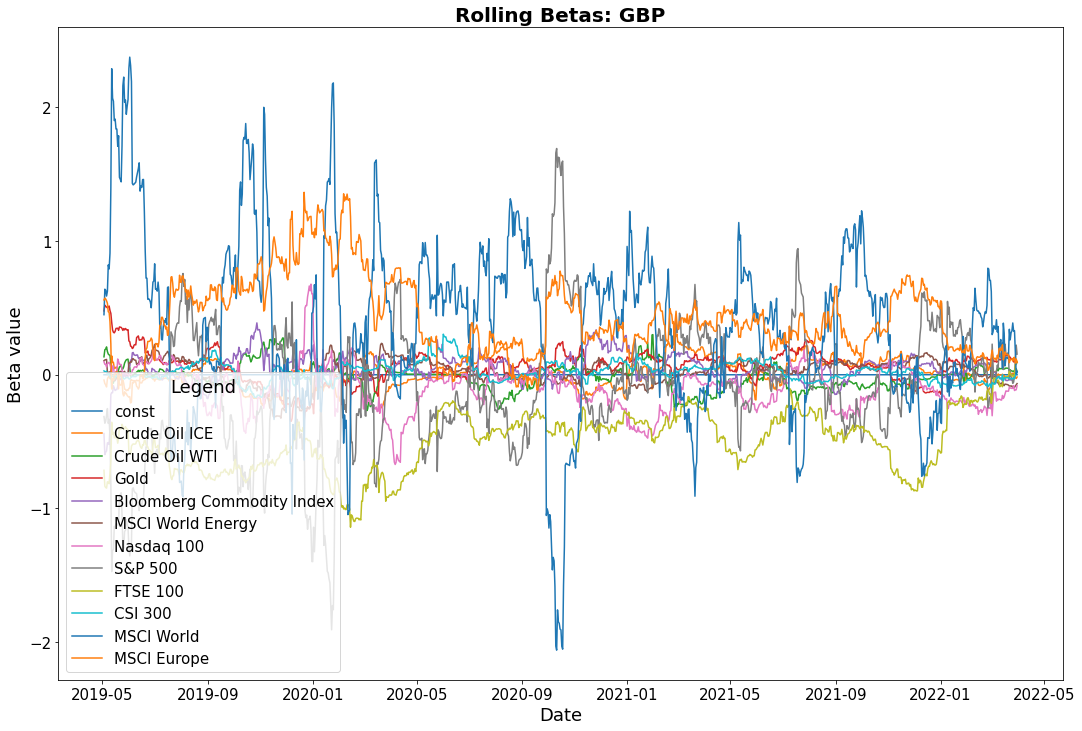

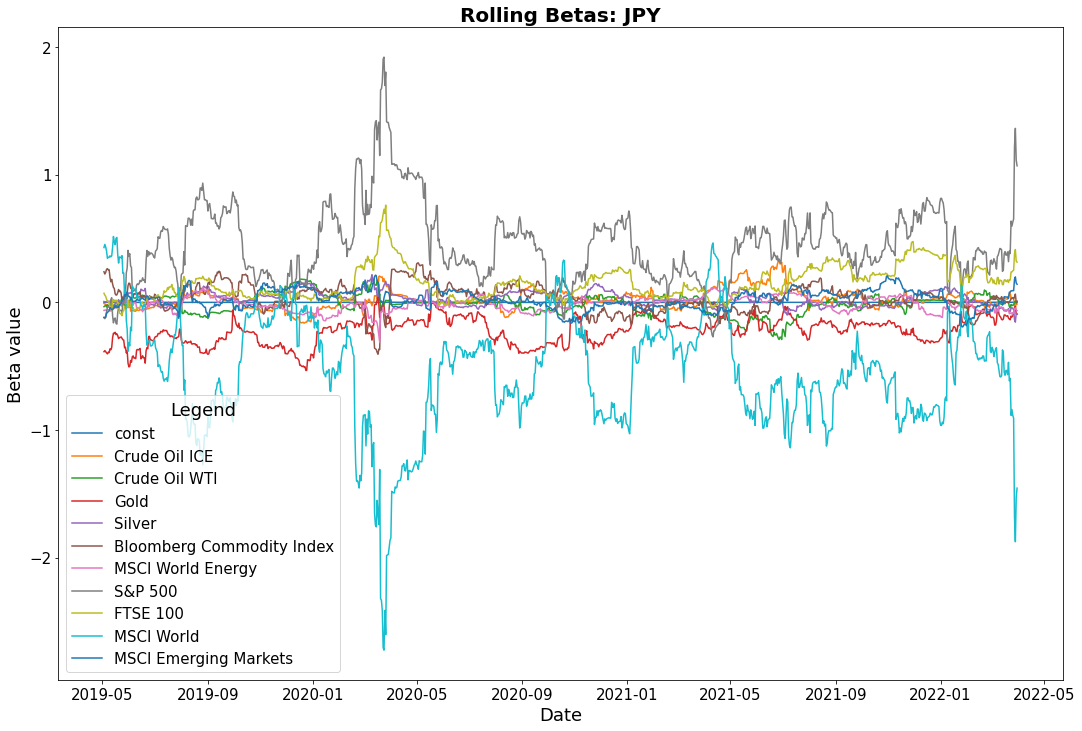

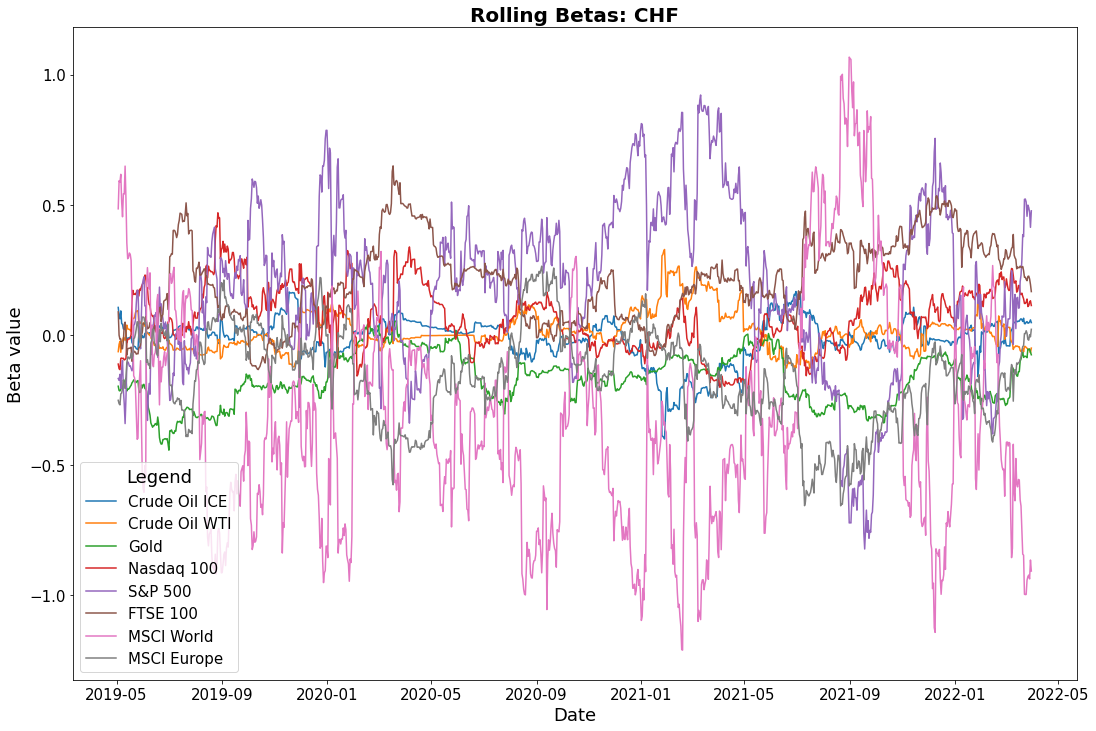

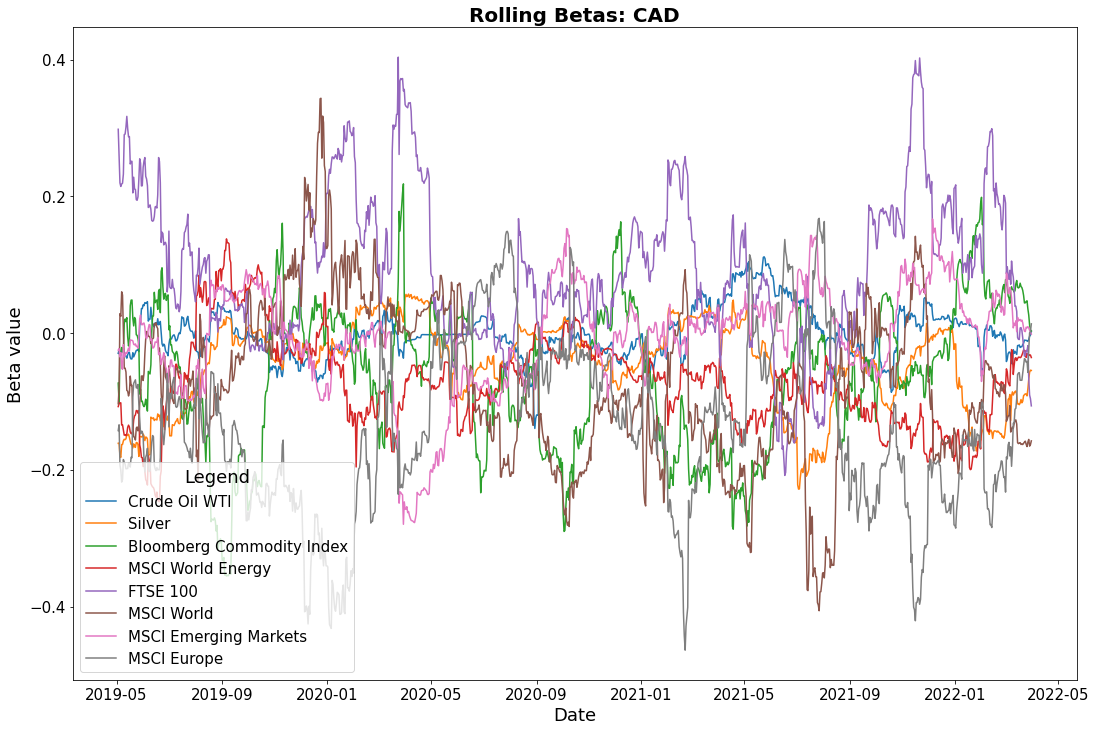

In [29]:
#Loop to take combination of explanatory variables with the highest adjusted r-squared
#run the rolling window regression and the chow test
#plot and print the results and save the charts

for i in range(len(r_squared_adjusted_list)):
    print(i)
    print(y_input.columns[i])
    #Set the data
    Y = y_input[y_input.columns[i]] #target value => index
    r_squared_list_index = r_squared_adjusted_list[i] #list of list of adjusted r squared (per (crypto-)currency)
    index_max_r_squared_adj = r_squared_list_index.index(max(r_squared_list_index)) #index of maximal adjusted r squared
    print("Maximal R Squared: "+ str(max(r_squared_list_index)))
    
    features_best = features_list[index_max_r_squared_adj] #explanatory variables according to the adjusted r squared
    X_best = x_input[features_best] #DataFrame with the explanatory variables according to the adjusted r squared
    rolling_ols = rolling_regression(Y,X_best,60,method = "package") #run function for rolling window regression
    chowtest = chow_test(Y,X_best)
    print("_____________________________________________________")
    
    fig, ax = plt.subplots(figsize=(18, 12)) #Plot
    ax.plot(rolling_ols)
    plt.title("Rolling Betas: " + Y.name, fontweight = "bold", fontsize = 20)
    ax.set(xlabel = "date", ylabel = "Beta Value")
    ax.set_xlabel('Date',fontsize = 18)
    ax.set_ylabel('Beta value',fontsize = 18)
    ax.tick_params(axis = "both", labelsize = 15)
    plt.legend(rolling_ols.columns, title = "Legend", fontsize = 15, title_fontsize = 18, loc = "lower left")
    plt.savefig("Charts_RWR/RWR_"+Y.name+"_.png")

In [30]:
#since pandas.index.strftime() results in errors when plotting, we run the loop for the chow test and rolling window regression another time
#and save the results in a newly created SQLite database


#create a SQLite table
conn = sqlite3.connect('AQM_Project_Aziz_Oeggerli_Schmid.db')
c = conn.cursor()
c.execute('''CREATE TABLE RWR_betas
            (Date TIMESTAMP,
            Var_dependent char(60),
            Var_independent char(60) NOT NULL,
            Beta REAL)''')
print("Table created successfully")


for i in range(len(r_squared_adjusted_list)):
    print(i)
    print(y_input.columns[i])
    
    #Set the data
    Y = y_input[y_input.columns[i]] #target value => index
    r_squared_list_index = r_squared_adjusted_list[i] #list of list of adjusted r squared (per index)
    index_max_r_squared_adj = r_squared_list_index.index(max(r_squared_list_index)) #index of max adj. r squared
    features_best = features_list[index_max_r_squared_adj] #explanatory variables according to the adj. r squared
    X_best = x_input[features_best] #DataFrame with the explanatory variables according to the adj. r squared
    rolling_ols = rolling_regression(Y,X_best,60,method = "package") #run function for rolling window regression
    
    
    #Transform Rolling OLS DataFrame into wide format and upload it into the SQLite database
    index = rolling_ols.index.strftime('%Y-%m-%d')
    rolling_ols['Date1'] = index #create new index
    rolling_ols['Name'] = y_input.columns.values.tolist()[i]
    rolling_ols_to_insert = pd.melt(rolling_ols, id_vars = ['Date1','Name'], value_vars = rolling_ols.columns.values.tolist()[:-2])
    rolling_ols_to_insert_list = rolling_ols_to_insert.values.tolist()
    
    
    #Upload data to SQL-database
    c.executemany('INSERT INTO RWR_betas(Date,Var_dependent,Var_independent,Beta) VALUES(?,?,?,?)',rolling_ols_to_insert_list)
    conn.commit()
    print("The Betas from the rolling window regression of the " + y_input.columns[i]+ " were uploaded sucessfully into the SQLite database")
    print("_____________________________________________________")

Table created successfully
0
Bitcoin
The length of the explanatory variables corresponds to the length of the target variable
The Betas from the rolling window regression of the Bitcoin were uploaded sucessfully into the SQLite database
_____________________________________________________
1
Ethereum
The length of the explanatory variables corresponds to the length of the target variable
The Betas from the rolling window regression of the Ethereum were uploaded sucessfully into the SQLite database
_____________________________________________________
2
Ripple
The length of the explanatory variables corresponds to the length of the target variable
The Betas from the rolling window regression of the Ripple were uploaded sucessfully into the SQLite database
_____________________________________________________
3
Litecoin
The length of the explanatory variables corresponds to the length of the target variable
The Betas from the rolling window regression of the Litecoin were uploaded sucess